# z2z Metadata analysis

Analysis of z2z metadata

By Isthmus // Mitchell P. Krawiec-Thayer

## Import Libraries
(if you have any issues with the next cell, run `pip install -r requirements.txt` to install dependencies)

In [1]:
import isthmuslib as isli
import pandas as pd
import os as os

## Set parameters

In [2]:
data_file_path = os.path.join(os.path.curdir,'..','data','version_controlled')
data_file_name = 'example.csv'

## Import data

Load from file

In [3]:
df = pd.read_csv(os.path.join(data_file_path, data_file_name))
df.head()

,x,y
0,5.959839,0.090399
1,1.108213,0.033029
2,1.500127,3.983496
3,4.694460,3.155247
4,-0.364907,-2.418327


## Data overview

In [4]:
df.describe()

,x,y
count,500.000000,500.000000
mean,1.999689,0.833486
std,2.123579,2.999099
min,-4.240503,-7.665807
25%,0.561652,-1.109777
50%,2.024033,0.889748
75%,3.539978,2.817497
max,7.228379,9.243297


## Data visualizations

### Histograms

Single variable

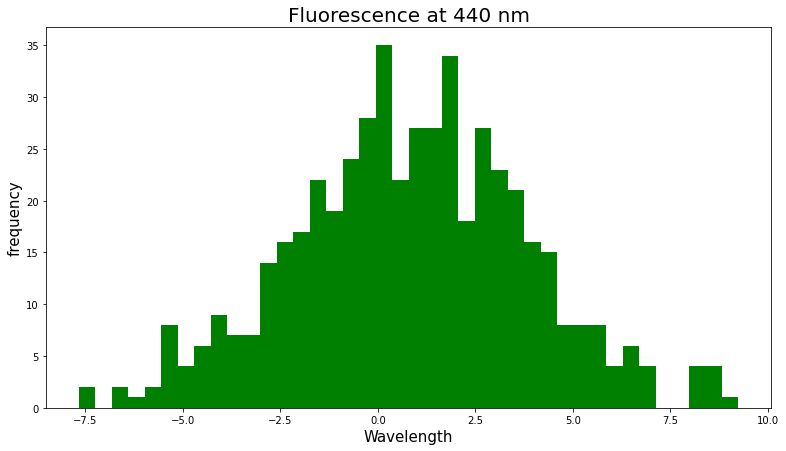

In [5]:
isli.hist(df['y'], xlabel='Wavelength', title='Fluorescence at 440 nm', bins=40);

Multiple variables

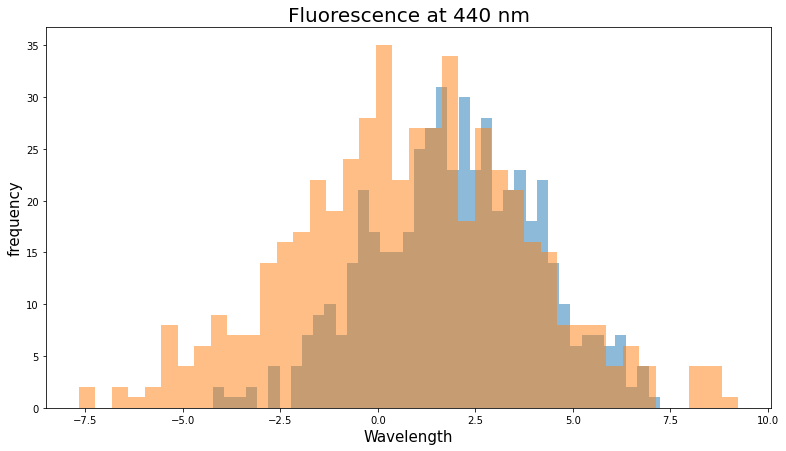

In [6]:
dataDict = {"Neutral (pH=6.93)":df['x'], "Acidic (pH=4.47)":df['y']}
isli.hist(dataDict, xlabel='Wavelength', title='Fluorescence at 440 nm', alpha=0.5, bins=40);

### Scatter plots

With markers

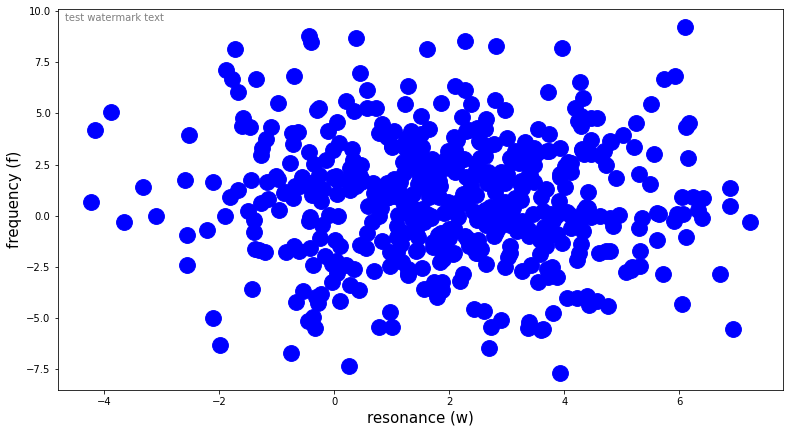

In [7]:
isli.scatter(df['x'], df['y'], watermarkText='test watermark text', markersize=250, xlabel='resonance (w)', ylabel='frequency (f)', markercolor='blue');

As a 2D histogram

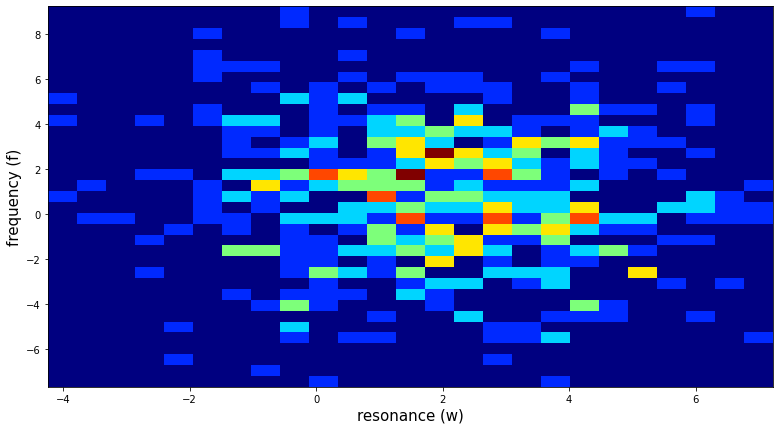

In [8]:
isli.hist2d(df['x'],df['y'], xlabel='resonance (w)', ylabel='frequency (f)', cmap='jet', bins=[25,35]);